# Day 17 - computational geometry with intervals, again!

- [Day 17](https://adventofcode.com/2018/day/17)

Remember the [overlapping rectangles of day 3](./Day%2003.ipynb)? This is a very similar problem.

If you see each `y` layer as a set of intervals (with side walls an interval 1 unit wide), we can once again solve this problem with a sweep line.

1. we keep two queues: one to handle water flowing down, the other to handle filling water into an area.
2. the intervals have a value associated with them; they are either clay, flowing water, or standing water.
3. you sweep down from the water source with a new interval at every line; flowing water with size 1, as long as you don't intersect another interval at that level.
4. When you do intersect (either with clay or with standing water), add that position to the other queue, to fill. Break out of the flow loop and go straight to the filling, because otherwise you end up with multiple flows into the same basin to handle.
5. Filling means we find the widest extend of adjacent intervals on the line below, and find the nearest edges to the left and right. We can replace the flowing water interval with either a standing water interval that fits between the edges we found, or a flowing water interval if an edge is missing or to far away from the supporting interval. In that case, we add a new flow to the first queue.

There is an edge-case we need to account for: we can have multiple flows coming into the same 'bucket', so when we pop an item from the queue, we first need to account for the area now being filled already. We also need to clean up flows into a bucket other than our own if we find them.

We can get away with a sorted list of interval objects here as we are covering lines of maybe 250 coordinates wide, then use [bisection](https://docs.python.org/3/library/bisect.html) to find intersections and edges. Otherwise we could reach for a full-blown [interval tree](https://en.wikipedia.org/wiki/Interval_tree) library for Python, such as the [`intervaltree` package](https://pypi.org/project/intervaltree/).


In [1]:
import re
from bisect import bisect_left, bisect_right
from collections import deque
from dataclasses import dataclass, field
from enum import Enum
from typing import Deque, Dict, Iterable, List, Optional, Sequence, Tuple, Union


class TileType(Enum):
    clay = "#"
    standing = "~"
    flowing = "|"


@dataclass(order=True)
class Interval:
    type: TileType = field(compare=False)
    start: int
    stop: int

    def __post_init__(self) -> None:
        assert self.stop > self.start

    def __contains__(self, idx: int) -> bool:
        return self.start <= idx < self.stop

    def __len__(self) -> int:
        return self.stop - self.start

    def overlaps(self, other: Union[slice, "Interval"]) -> bool:
        # treat open ends as 0 and self.stop, respectively
        ostart = 0 if other.start is None else other.start
        ostop = self.stop if other.stop is None else other.stop
        return self.start < ostop and self.stop > ostart


ScanlineIndex = Union[int, slice, Interval]


class Scanline:
    intervals: List[Interval]

    def __init__(self) -> None:
        self.intervals = []
        self._starts: List[int] = []

    def __repr__(self) -> str:
        line = []
        last = 0
        for i in self.intervals:
            if last:
                line += ["."] * (i.start - last)
            line += [i.type.value] * len(i)
            last = i.stop
        return (
            f'<{type(self).__name__} ({min(self._starts, default=0)}) {"".join(line)}>'
        )

    def __len__(self):
        return len(self.intervals)

    def __iter__(self):
        return iter(self.intervals)

    def __getitem__(self, idx: int) -> Optional[Interval]:
        """Retrieve a single interval at the given index"""
        i = bisect_right(self._starts, idx)
        if i > 0 and idx in self.intervals[i - 1]:
            return self.intervals[i - 1]
        return None

    def __delitem__(self, idx: ScanlineIndex) -> None:
        """Remove the interval at idx from this scanline"""
        if isinstance(idx, int):
            idx = slice(idx, idx + 1)
        i = bisect_left(self._starts, idx.start)
        if i == len(self.intervals):
            raise IndexError(idx)
        del self._starts[i], self.intervals[i]

    def __setitem__(self, idx: ScanlineIndex, type: TileType) -> None:
        """Set a portion of this line to be an interval of a given type

        Merges overlapping intervals, provided they are of the same type

        """
        if isinstance(idx, int):
            idx = slice(idx, idx + 1)
        # merge existing intervals
        interval = Interval(type, idx.start, idx.stop)
        for intersection in self.intersections(idx):
            assert intersection.type is type
            interval.start = min(interval.start, intersection.start)
            interval.stop = max(interval.stop, intersection.stop)
            del self[intersection]

        # merge directly adjacent intervals of the same type
        while True:
            left = self[interval.start - 1]
            if left is None or left.type is not interval.type:
                break
            assert interval.type is not TileType.flowing
            interval.start = left.start
            del self[left]
        while True:
            right = self[interval.stop]
            if right is None or right.type is not interval.type:
                break
            assert interval.type is not TileType.flowing
            interval.stop = right.stop
            del self[right]

        # Python's TimSort is really efficient for already mostly-sorted lists
        # so we can get away with using that here rather than use bisection and
        # insertion sort. We have at most a dozen intervals per line anyway.
        self.intervals.append(interval)
        self.intervals.sort()
        self._starts.append(interval.start)
        self._starts.sort()

    def intersections(self, idx: ScanlineIndex) -> Sequence[Interval]:
        """Find all intersections between idx and an interval on this line"""
        if isinstance(idx, int):
            idx = slice(idx, idx + 1)
        # replace open-ended intervals with -1 and our last .stop value + 1, respectively
        if idx.start is None:
            idx = slice(-1, idx.stop)
        if idx.stop is None:
            idx = slice(idx.start, self.intervals[-1].stop + 1 if self else 1)
        first = max(bisect_left(self._starts, idx.start) - 1, 0)
        found = []
        for i in range(first, len(self.intervals)):
            if idx.stop <= self._starts[i]:
                break
            if idx.start < self.intervals[i].stop:
                found.append(self.intervals[i])
        return found

    def adjacent(
        self, idx: ScanlineIndex
    ) -> Tuple[Optional[Interval], Optional[Interval]]:
        """Produce intervals to the left and right of the idx value.

        If the given index overlaps, (None, None) is returned.

        """
        if isinstance(idx, int):
            idx = slice(idx, idx + 1)
        i = bisect_left(self._starts, idx.stop) - 1
        before = self.intervals[i] if i >= 0 else None
        if before and before.overlaps(idx):
            return None, None
        after = self.intervals[i + 1] if i + 1 < len(self.intervals) else None
        if after and after.overlaps(idx):
            return None, None
        return before, after

    def extends(self, idx: ScanlineIndex) -> Optional[slice]:
        """Return a slice covering a full extend of positions that intersects with idx

        idx can overlap only partly with the interval returned.

        Returns None if there are no or multiple non-contiguous intersections that
        overlap with idx.

        """
        intersections = self.intersections(idx)
        if not intersections:
            return None
        start, stop = intersections[0].start, intersections[0].stop
        # intersections are returned in sorted order, from left to right
        for intersection in intersections[1:]:
            if intersection.start > stop:
                # Not contigious
                return None
            stop = intersection.stop
        # extend left and right
        while True:
            left = self[start - 1]
            if left is None:
                break
            start = left.start
        while True:
            right = self[stop]
            if right is None:
                break
            stop = right.stop
        return slice(start, stop)


_parse_line = re.compile(
    r"(?P<xy>[xy])=(?P<point>\d+), " r"[xy]=(?P<start>\d+)\.\.(?P<stop>\d+)"
).search


class Reservoir:
    def __init__(self, scanlines: Sequence[Scanline]) -> None:
        self.scanlines = scanlines
        self._first_y = next(y for y, scanline in enumerate(scanlines) if scanline)

    @classmethod
    def from_lines(cls, lines: Iterable[str]) -> "Reservoir":
        scanlines = []
        for line in lines:
            m = _parse_line(line)
            if m is None:
                continue
            point, start, stop = map(int, (m["point"], m["start"], m["stop"]))
            if m["xy"] == "x":
                xslice, yrange = slice(point, point + 1), range(start, stop + 1)
            else:
                yrange, xslice = range(point, point + 1), slice(start, stop + 1)
            if len(scanlines) < yrange.stop:
                scanlines += [Scanline() for _ in range(yrange.stop - len(scanlines))]
            for y in yrange:
                scanlines[y][xslice] = TileType.clay
        return cls(scanlines)

    def fill(self, startx: int = 500) -> None:
        scanlines = self.scanlines

        # A queue of falling water, with (y, x) tuples
        toflow: Deque[Tuple[int, int]] = deque([(1, startx)])
        # filling water queue, (y, x) entries, where we are filling in from
        # an original incoming flow.
        tofill: Deque[Tuple[int, int]] = deque()

        # points were we overflowed a container. If this happens inside a larger
        # container, we need to detect this case as we fill back up to this level.
        # at that point we need to clear the overflow, and continue filling back
        # up the outer container using the original flow that created the overflow.
        # maps y coordinate to nested dictionary mapping overflow start point to
        # incoming flow x coordinate.
        overflows: Dict[int, Dict[int, int]] = {}

        while toflow or tofill:
            # first flow water down
            while toflow:
                y, x = toflow.popleft()
                scanline = scanlines[y]
                interval = scanline[x]
                if interval is None:
                    scanline[x] = TileType.flowing
                    if y + 1 < len(scanlines):
                        toflow.append((y + 1, x))
                elif interval.type is not TileType.flowing:
                    # we've hit an already-filled line (clay or standing water)
                    tofill.append((y - 1, x))

            # then process any filling / overspill actions
            while tofill:
                # time to go back and poor in standing water.
                y, x = tofill.popleft()
                scanline = scanlines[y]
                interval = scanline[x]
                if interval is None:
                    # our incoming flow is gone, abort
                    continue
                if interval.type is TileType.standing:
                    # there were multiple flows, and we've been flooded
                    # back up a step if we can
                    above = scanlines[y - 1][x]
                    if above is not None and above.type is TileType.flowing:
                        tofill.append((y - 1, x))
                    continue
                assert interval.type is TileType.flowing
                if interval.start in overflows.get(y, {}):
                    # we filled back up to an overflow, reset our x
                    # coordinate to become the original incoming flow
                    x = overflows[y].pop(interval.start)

                # remove an incoming flow; if this is actually an overflow,
                # it'll be re-applied here; it may now need to be wider
                # to cover newly-added standing water.
                del scanline[interval]

                # The surface we flow on top of is taken from the next line.
                surface = scanlines[y + 1].extends(x)

                # find nearest 'walls' to fill
                while True:
                    edges = scanline.adjacent(x)
                    for edge in edges:
                        if (
                            edge is not None
                            and edge.type is TileType.flowing
                            and edge.overlaps(surface)
                        ):
                            # this is another flow hitting the same surface.
                            # remove it here, we'll detect this case when handling
                            # that flow job another iteration.
                            del scanline[edge]
                            break
                    else:
                        left, right = edges
                        break

                # The water is assumed to be standing unless proven otherwise.
                type = TileType.standing

                # Determine how far to fill with water, and if we overflow
                if left is None or surface.start >= left.stop:
                    # overflow on the left, add a new down flow to the queue
                    # BUT, only if not already flowing at this edge!
                    if scanlines[y + 1][surface.start].type is not TileType.flowing:
                        toflow.append((y + 1, surface.start - 1))
                        surface = slice(surface.start - 1, surface.stop)
                    type = TileType.flowing
                else:
                    # adjust the left edge to start against the 'wall'
                    surface = slice(left.stop, surface.stop)
                if right is None or surface.stop < right.start:
                    # overflow on the left, add a new down flow to the queue
                    # BUT, only if not already flowing at this edge!
                    if scanlines[y + 1][surface.stop - 1].type is not TileType.flowing:
                        toflow.append((y + 1, surface.stop))
                        surface = slice(surface.start, surface.stop + 1)
                    type = TileType.flowing
                else:
                    # adjust the right edge to start against the 'wall'
                    surface = slice(surface.start, right.start)

                scanline[surface] = type
                if type is TileType.standing:
                    # we'll need to continue with filling this section
                    tofill.append((y - 1, x))
                else:
                    # we have an overflow here, record this in case a
                    # larger, encompasing container exists and standing water
                    # reaches up to this point.
                    overflows.setdefault(y, {})[surface.start] = x

    def total_flow(self) -> int:
        return sum(
            len(interval)
            for y, sl in enumerate(self.scanlines)
            if y >= self._first_y
            for interval in sl
            if interval.type is not TileType.clay
        )

    def total_standing(self) -> int:
        return sum(
            len(interval)
            for y, sl in enumerate(self.scanlines)
            for interval in sl
            if interval.type is TileType.standing
        )

In [2]:
testreservoir = Reservoir.from_lines(
    """\
x=495, y=2..7
y=7, x=495..501
x=501, y=3..7
x=498, y=2..4
x=506, y=1..2
x=498, y=10..13
x=504, y=10..13
y=13, x=498..504""".splitlines()
)
testreservoir.fill()
assert testreservoir.total_flow() == 57

In [3]:
import aocd

data = aocd.get_data(day=17, year=2018)

In [4]:
reservoir = Reservoir.from_lines(data.splitlines())
reservoir.fill()
print("Part 1:", reservoir.total_flow())

Part 1: 34775


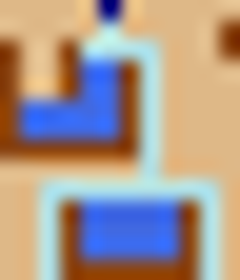

In [5]:
from PIL import Image


def visualise(reservoir: Reservoir, scale=1) -> Image.Image:
    minx, maxx = float("inf"), 0
    height = len(reservoir.scanlines)
    for scanline in reservoir.scanlines:
        if not scanline:
            continue
        minx = min(minx, scanline.intervals[0].start)
        maxx = max(maxx, scanline.intervals[-1].stop)

    width = maxx - minx
    img = Image.new("RGB", (width, height), (0xDE, 0xB8, 0x87))
    colours = {
        TileType.clay: (0x8B, 0x45, 0x13),
        TileType.standing: (0x41, 0x69, 0xE1),
        TileType.flowing: (0xB0, 0xE0, 0xE6),
    }
    # the tap
    img.putpixel((500 - minx, 0), (0, 0, 0x80))
    for y, scanline in enumerate(reservoir.scanlines):
        for interval in scanline.intervals:
            for x in range(interval.start, interval.stop):
                img.putpixel((x - minx, y), colours[interval.type])
    if scale != 1:
        img = img.resize((img.width * scale, img.height * scale))
    return img


visualise(testreservoir, 20)

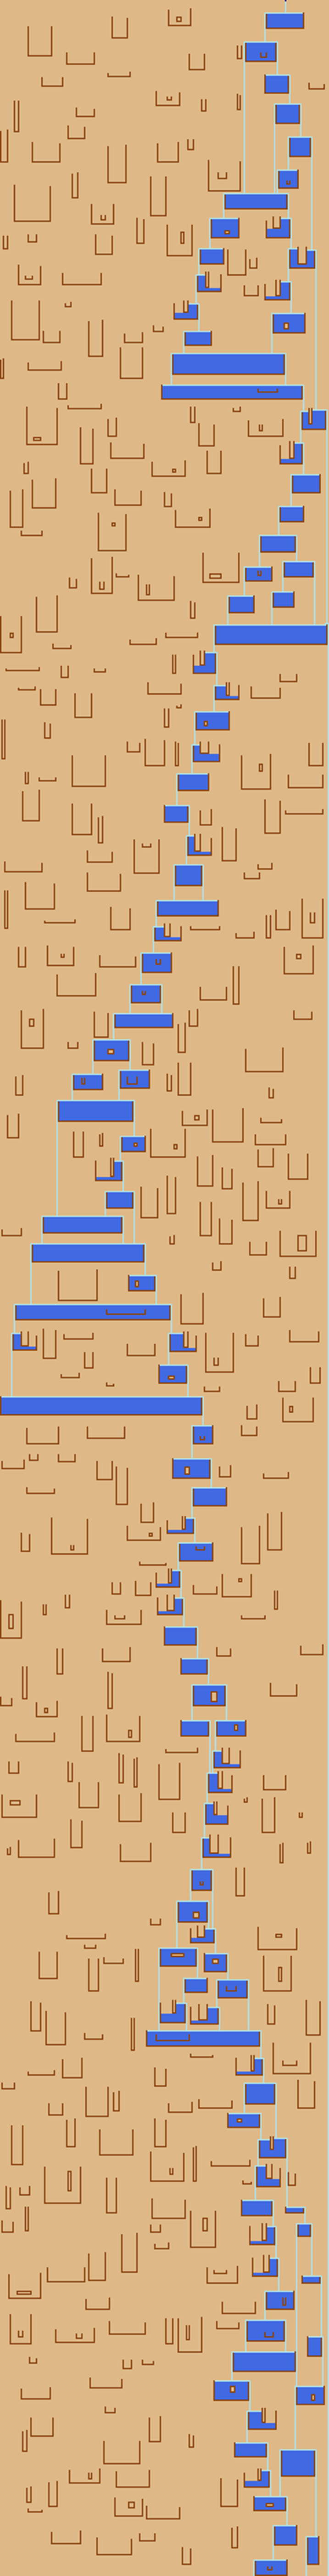

In [6]:
visualise(reservoir, 3)

## Part 2, count only standing water.

We made it real easy to solve part 2; just count the standing water intervals


In [7]:
assert testreservoir.total_standing() == 29

In [8]:
print("Part 2:", reservoir.total_standing())

Part 2: 27086
